In [10]:
import os
import sys
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import asyncio
import nest_asyncio
nest_asyncio.apply()

# Add the directory where dynamics.py and utils.py are located to sys.path
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

generate_random_graph = False
maximize_independent_C_nodes = False

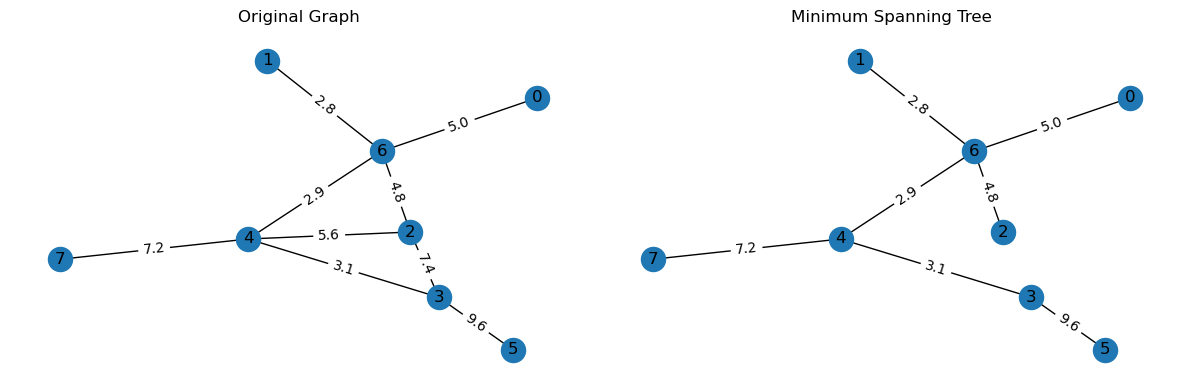

In [11]:
if generate_random_graph:
    # Generate a random graph
    number_of_nodes = 8
    number_of_edges = 9
    G = nx.gnm_random_graph(number_of_nodes, number_of_edges)
    
    # Ensure the graph is connected
    while not nx.is_connected(G):
        # Find connected components
        components = list(nx.connected_components(G))
        for i in range(1, len(components)):
            node_from_prev = list(components[i - 1])[0]
            node_from_curr = list(components[i])[0]
            G.add_edge(node_from_prev, node_from_curr)
            
    # Add random weights to the edges
    for (u, v) in G.edges():
        # Only with one decimal place
        G[u][v]['weight'] = round(np.random.uniform(0.1, 10), 1)
else:
    # Define the graph
    edges_with_weights = [
        (0, 6, 5.0),
        (1, 6, 2.8),
        (6, 4, 2.9),
        (6, 2, 4.8),
        (2, 4, 5.6),
        (4, 3, 3.1),
        (4, 7, 7.2),
        (3, 5, 9.6),
        (3, 2, 7.4)
    ]

    # Create the graph
    G = nx.Graph()
    G.add_weighted_edges_from(edges_with_weights)
        
# Compute the layout for the graph
pos = nx.spring_layout(G)

# Compute the Minimum Spanning Tree (MST) using NetworkX's API
MST = nx.minimum_spanning_tree(G, weight='weight')

# Visualize the graph and MST in 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot the original graph
plt.sca(axes[0])
nx.draw(G, pos, with_labels=True, ax=axes[0])
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=axes[0])
axes[0].set_title("Original Graph")

# Plot the Minimum Spanning Tree
plt.sca(axes[1])
nx.draw(MST, pos, with_labels=True, ax=axes[1])
edge_labels = nx.get_edge_attributes(MST, 'weight')
nx.draw_networkx_edge_labels(MST, pos, edge_labels=edge_labels, ax=axes[1])
axes[1].set_title("Minimum Spanning Tree")

plt.tight_layout()
plt.show()

In [12]:
# Compute parent and children relationships for the MST
parent_children = {}

# Use a Depth-First Search (DFS) to extract parent-child relationships
for edge in nx.dfs_edges(MST):
    parent, child = edge
    # Add child to parent's list
    if parent not in parent_children:
        parent_children[parent] = {'children': [], 'parent': None}
    if child not in parent_children:
        parent_children[child] = {'children': [], 'parent': None}
    parent_children[parent]['children'].append(child)
    # Set child's parent
    parent_children[child]['parent'] = parent

# Display the parent-children relationships
node_relationships = {
    node: {
        "Parent": relationships["parent"],
        "Children": relationships["children"]
    }
    for node, relationships in parent_children.items()
}

# Display the parent-children relationships without ace_tools
df = pd.DataFrame(node_relationships).T

# Add the 'Degree' column (number of children + 1 if parent exists)
df['Degree'] = df['Children'].apply(len) + df['Parent'].notnull().astype(int)

if maximize_independent_C_nodes:
    # Reset roles to 'D'
    df['Role'] = 'D'

    # Initialize set to track nodes assigned as 'C'
    assigned_C_nodes = set()

    # Sort nodes by their degree (ascending) to prioritize leaf nodes first
    nodes_sorted_by_degree = df['Degree'].sort_values().index

    # Assign 'C' to as many nodes as possible without direct connections in the original graph
    for node in nodes_sorted_by_degree:
        neighbors = set(G.neighbors(node))
        if not assigned_C_nodes.intersection(neighbors):  # Ensure no neighbors are already 'C'
            df.loc[node, 'Role'] = 'C'
            assigned_C_nodes.add(node)
else: # Maximize the degree of 'C' nodes while ensuring no direct neighbors are 'C'
    # Reset roles to 'D'
    df['Role'] = 'D'

    # Initialize set to track nodes assigned as 'C'
    assigned_C_nodes = set()

    # Sort nodes by their degree (descending) to prioritize high-degree nodes first
    nodes_sorted_by_degree = df['Degree'].sort_values(ascending=False).index

    # Assign 'C' to as many nodes as possible while maximizing the degree and ensuring no direct neighbors are 'C'
    for node in nodes_sorted_by_degree:
        neighbors = set(G.neighbors(node))
        if not assigned_C_nodes.intersection(neighbors):  # Ensure no neighbors are already 'C'
            df.loc[node, 'Role'] = 'C'
            assigned_C_nodes.add(node)
    
# Display
df.sort_index()

,Parent,Children,Degree,Role
0,None,[6],1,D
1,6,[],1,D
2,6,[],1,D
3,4,[5],2,C
4,6,"[3, 7]",3,D
5,3,[],1,D
6,0,"[1, 4, 2]",4,C
7,4,[],1,C


In [13]:
nx.laplacian_matrix(MST, weight=None).toarray()

array([[ 1, -1,  0,  0,  0,  0,  0,  0],
       [-1,  4, -1, -1, -1,  0,  0,  0],
       [ 0, -1,  1,  0,  0,  0,  0,  0],
       [ 0, -1,  0,  3,  0, -1, -1,  0],
       [ 0, -1,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  2,  0, -1],
       [ 0,  0,  0, -1,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0, -1,  0,  1]])

In [16]:
class Node:
    def __init__(self, node_id, children, parent, degree, role, is_root=False):
        self.node_id = node_id
        self.children = children
        self.parent = parent
        self.degree = degree
        self.role = role
        self.received_from_children = set()  # Track messages received from children
        self.message_sent_to_parent = False  # Track if the node has sent its message to the parent
        self.message_received_from_parent = is_root  # Root starts with received message from "itself"

    async def narrowcast_parent(self, network, message):
        """Send a message to the parent."""
        if self.parent is not None:
            print(f"[L to R] Node {self.node_id} -> Parent {self.parent} sending: {message}")
            await network[self.parent].put((self.node_id, message))
            self.message_sent_to_parent = True

    async def broadcast_children(self, network, message):
        """Broadcast a message to all children."""
        for child in self.children:
            print(f"[R to L] Node {self.node_id} -> Child {child} broadcasting: {message}")
            await network[child].put((self.node_id, message))

    async def handle_message(self, sender, message, network):
        """Handle incoming messages."""
        print(f"Node {self.node_id} received from Node {sender}: {message}")

        if sender in self.children:
            self.received_from_children.add(sender)

        if sender == self.parent:
            self.message_received_from_parent = True

        # Upward phase: Send to parent after receiving from all children
        if not self.message_sent_to_parent:
            if self.received_from_children == set(self.children):
                await self.narrowcast_parent(network, f"(b_{self.node_id}, p_{self.node_id})")

        # Downward phase: Broadcast to children after receiving from parent
        if self.message_received_from_parent and self.children:
            await self.broadcast_children(network, f"b_{self.node_id}")

    async def run(self, network, termination_event):
        """Simulate the node's behavior."""
        # If the node is a leaf, it starts by sending a message to its parent
        if not self.children:
            await self.narrowcast_parent(network, f"(b_{self.node_id}, p_{self.node_id})")

        while not termination_event.is_set():
            try:
                # Wait for incoming messages
                sender, message = await asyncio.wait_for(network[self.node_id].get(), timeout=0.5)
                await self.handle_message(sender, message, network)
            except asyncio.TimeoutError:
                pass

In [17]:
# Simulate the network
async def simulate(node_info):
    # Create communication channels for nodes
    network = {node: asyncio.Queue() for node in node_info}

    # Initialize nodes
    root_node = next(node for node, info in node_info.items() if info["Parent"] is None)
    nodes = {
        node: Node(
            node_id=node,
            children=node_info[node]["Children"],
            parent=node_info[node]["Parent"],
            degree=node_info[node]["Degree"],
            role=node_info[node]["Role"],
            is_root=(node == root_node),  # Set root node
        )
        for node in node_info
    }

    # Create a termination event
    termination_event = asyncio.Event()

    # Run all nodes asynchronously
    tasks = [asyncio.create_task(nodes[node].run(network, termination_event)) for node in nodes]

    # Wait until all leaf nodes terminate
    all_leaves_done = False
    while not all_leaves_done:
        await asyncio.sleep(0.1)
        all_leaves_done = all(
            node.message_received_from_parent or not node.children for node in nodes.values()
        )

    print("All nodes have completed the downward communication phase.")

    # Signal termination
    termination_event.set()
    for task in tasks:
        task.cancel()

    print("Simulation complete.")


# Run the simulation with the MST and parent-children relationships
loop = asyncio.get_event_loop()
loop.run_until_complete(simulate(node_info=df.to_dict(orient="index")))

[L to R] Node 1 -> Parent 6 sending: (b_1, p_1)
[L to R] Node 5 -> Parent 3 sending: (b_5, p_5)
[L to R] Node 7 -> Parent 4 sending: (b_7, p_7)
[L to R] Node 2 -> Parent 6 sending: (b_2, p_2)
Node 6 received from Node 1: (b_1, p_1)
Node 4 received from Node 7: (b_7, p_7)
Node 3 received from Node 5: (b_5, p_5)
[L to R] Node 3 -> Parent 4 sending: (b_3, p_3)
Node 6 received from Node 2: (b_2, p_2)
Node 4 received from Node 3: (b_3, p_3)
[L to R] Node 4 -> Parent 6 sending: (b_4, p_4)
Node 6 received from Node 4: (b_4, p_4)
[L to R] Node 6 -> Parent 0 sending: (b_6, p_6)
Node 0 received from Node 6: (b_6, p_6)
[R to L] Node 0 -> Child 6 broadcasting: b_0
Node 6 received from Node 0: b_0
[R to L] Node 6 -> Child 1 broadcasting: b_6
[R to L] Node 6 -> Child 4 broadcasting: b_6
[R to L] Node 6 -> Child 2 broadcasting: b_6
Node 1 received from Node 6: b_6
Node 4 received from Node 6: b_6
[R to L] Node 4 -> Child 3 broadcasting: b_4
[R to L] Node 4 -> Child 7 broadcasting: b_4
Node 2 received